In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [16]:

def display_images(images):
    _, axes = plt.subplots(2, 2, figsize=(6, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

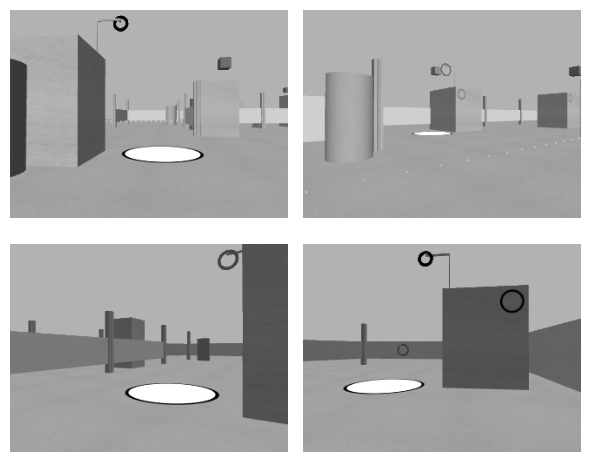

In [81]:
path = "/home/thelegend442/faxic/RINS-kappa/workspace/src/dis_tutorial5/images/"
img1 = cv2.imread(path + "gray_screen1.png")
img2 = cv2.imread(path + "gray_screen2.png")
img3 = cv2.imread(path + "gray_screen3.png")
img4 = cv2.imread(path + "gray_screen4.png")

images = [img1, img2, img3, img4]
display_images(images)

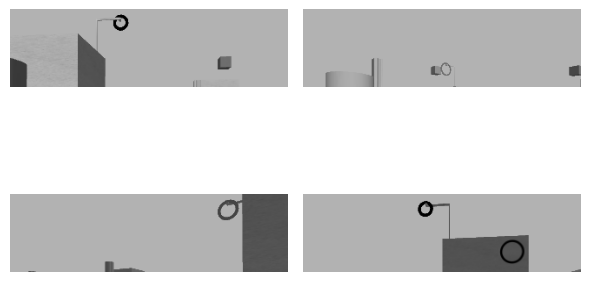

In [82]:
def cut_images(images):
    cut_images = []
    for image in images:
        cut_image = image[0:90,0:320]
        cut_images.append(cut_image)
    return cut_images
cutted_images = cut_images(images)
display_images(cutted_images)

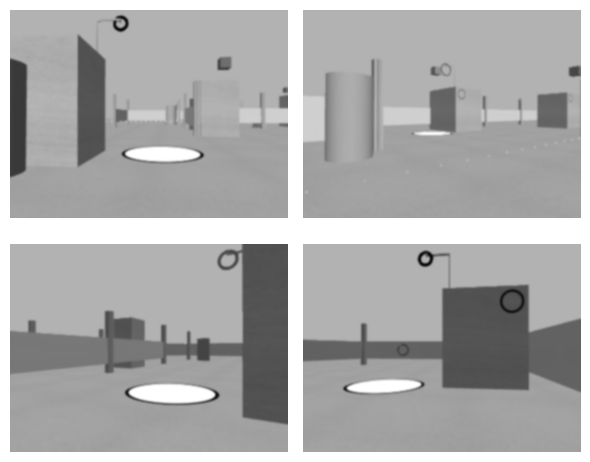

In [83]:

images_blured = []
for image in images:
    image_blured = cv2.GaussianBlur(image, (5, 5), 0)
    images_blured.append(image_blured)
display_images(images_blured)

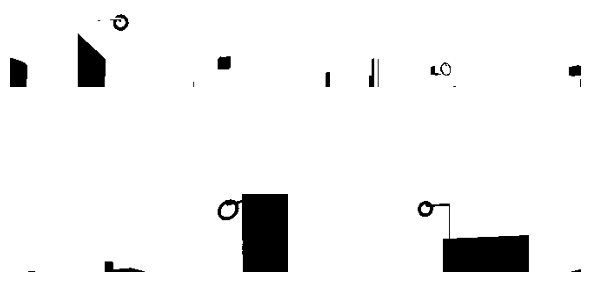

In [84]:
def otsu_thresholding(images, blur_ksize=(7, 7), apply_blur=True):
    thresholded_images = []
    for image in images:
        if apply_blur:
            image = cv2.GaussianBlur(image, blur_ksize, 0)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thresholded_images.append(thresh)
    return thresholded_images
thresholded_images = otsu_thresholding(cutted_images, blur_ksize=(7, 7), apply_blur=False)
display_images(thresholded_images)

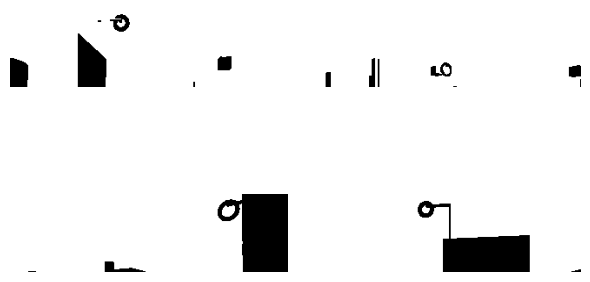

In [69]:
def perform_erosion(images, kernel_size=(3, 3), iterations=1):
    kernel = np.ones(kernel_size, np.uint8)
    eroded_images = []
    for image in images:
        eroded = cv2.erode(image, kernel, iterations=iterations)
        eroded_images.append(eroded)
    return eroded_images

eroded_images = perform_erosion(thresholded_images, kernel_size=(2, 2), iterations=1)
display_images(eroded_images)

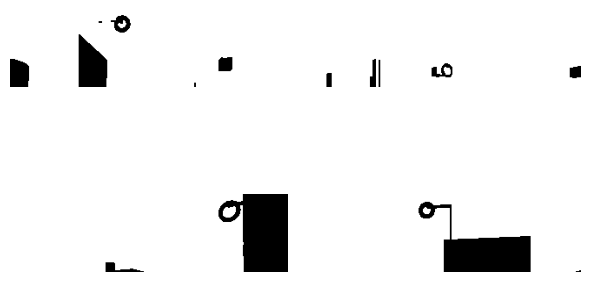

In [85]:
def perform_opening(images, kernel_size=(3, 3), iterations=1):
    kernel = np.ones(kernel_size, np.uint8)
    opened_images = []
    for image in images:
        opened = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=iterations)
        opened_images.append(opened)
    return opened_images

opened_images = perform_opening(eroded_images, kernel_size=(2, 2), iterations=1)
display_images(opened_images)

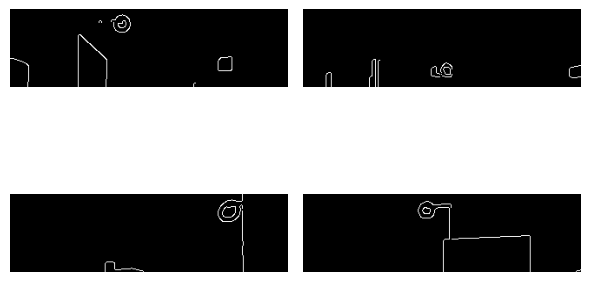

[[((25.537799835205078, 60.167930603027344), (15.53551959991455, 16.002504348754883), 144.95127868652344), ((247.3515625, 63.504268646240234), (17.052101135253906, 18.802343368530273), 57.061729431152344), ((247.34571838378906, 63.50923156738281), (16.434803009033203, 18.936805725097656), 53.93290328979492), ((93.97164916992188, 72.61710357666016), (33.7449836730957, 81.9769515991211), 170.1232452392578), ((128.8045654296875, 18.368274688720703), (7.135714054107666, 10.216928482055664), 61.586483001708984), ((128.0326690673828, 17.417463302612305), (19.364580154418945, 20.50147247314453), 109.76065063476562)], [((164.9562530517578, 75.26599884033203), (5.62941837310791, 12.537130355834961), 97.04063415527344), ((29.03428840637207, 82.60897827148438), (6.4559102058410645, 22.71017074584961), 1.2445406913757324), ((151.1197052001953, 72.78953552246094), (8.764749526977539, 13.190135955810547), 157.93240356445312), ((314.17181396484375, 72.22505950927734), (13.415648460388184, 18.56787109

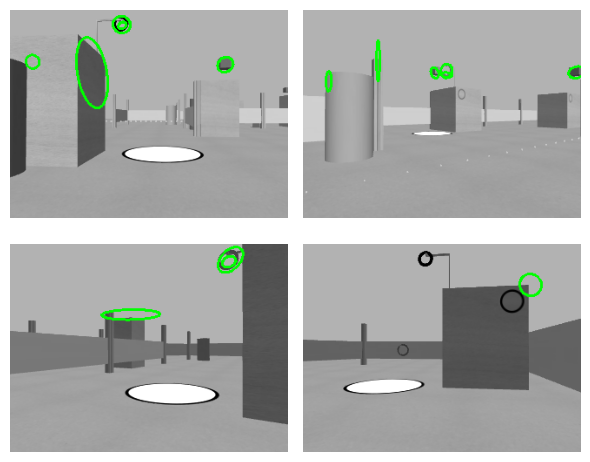

In [88]:
def find_ellipses(images, canny_threshold1=50, canny_threshold2=150, min_major_axis=10, max_major_axis=100):
    ellipses_per_img = []
    edges_images = []
    for image in images:
        ellipses = []
        # Apply Canny edge detection
        edges = cv2.Canny(image, canny_threshold1, canny_threshold2)
        edges_images.append(edges)
        # Find contours
        contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        
        for contour in contours:
            if len(contour) >= 5:  # Fit ellipse requires at least 5 points
                ellipse = cv2.fitEllipse(contour)
                (center, axes, angle) = ellipse
                major_axis = max(axes)
                if min_major_axis <= major_axis <= max_major_axis:
                    ellipses.append(ellipse)

        ellipses_per_img.append(ellipses)

    display_images(edges_images)
    return ellipses_per_img

ellipses_per_image = find_ellipses(opened_images)
print(ellipses_per_image)

def draw_ellipses(images, ellipses_per_image):
    images_copy = [img.copy() for img in images]
    for i, img in enumerate(images_copy):
        for ellipse in ellipses_per_image[i]:
            cv2.ellipse(img, ellipse, (0, 255, 0), 2)

    display_images(images_copy)

draw_ellipses(images, ellipses_per_image)

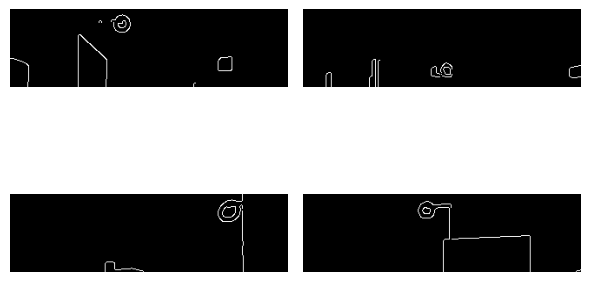

Detected 18 ellipses in total.


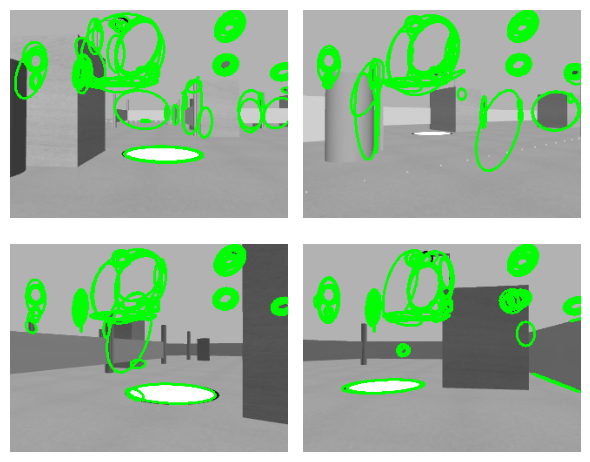

In [ ]:
def find_ellipses(opened_images, canny_threshold1=50, canny_threshold2=150, min_major_axis=10, max_major_axis=100):
    """Detects ellipses only in preprocessed (opened) images."""
    ellipses_per_image = []
    edges_images = []

    for opened_image in opened_images:
        # Convert to grayscale if necessary
        gray = cv2.cvtColor(opened_image, cv2.COLOR_BGR2GRAY) if len(opened_image.shape) == 3 else opened_image
        
        # Apply Canny edge detection
        edges = cv2.Canny(gray, canny_threshold1, canny_threshold2)
        edges_images.append(edges)

        # Find contours
        contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        ellipses = []

        for contour in contours:
            if len(contour) >= 20:  # Fit ellipse requires at least 5 points
                ellipse = cv2.fitEllipse(contour)
                (center, axes, angle) = ellipse
                major_axis = max(axes)

                if min_major_axis <= major_axis <= max_major_axis:
                    ellipses.append(ellipse)

        ellipses_per_image.append(ellipses)  # Store detected ellipses for this image

    display_images(edges_images)  # Show edge-detected images for debugging
    return ellipses_per_image

def draw_ellipses(original_images, ellipses_per_image):
    """Draws detected ellipses on original images."""
    for i, image in enumerate(original_images):
        # Convert grayscale images to BGR for proper color drawing
        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
            original_images[i] = image  # Update list in-place

        for ellipse in ellipses_per_image[i]:
            cv2.ellipse(image, ellipse, (0, 255, 0), 2)  # Draw in green

    display_images(original_images)  # Show final images

# Run functions
ellipses_per_image = find_ellipses(opened_images)  # Detect ellipses only in opened images
print(f"Detected {sum(len(e) for e in ellipses_per_image)} ellipses in total.")
draw_ellipses(images, ellipses_per_image)  # Draw them on original images
